
## Итерационные методы решения СЛАУ
Решаем систему

$$Ax=b$$ 

Итерационными методами называются приближенные методы, в которых решение системы получается как предел последовательности векторов $\{x^k\}_{k=0}^{\infty}$, каждый последующий элемент которой вычисляется по некоторому единому правилу. Начальное приближение решения $x^0$ в этой программе выбирается как столбец свободных членов $b$.

Последовательность $\{x^k\}_{k=0}^{\infty}$ называется итерационной, а её элементы последовательными итерациями (приближениями).

Важной характеристикой итерационного процесса является скорость схожимости итерационной последовательности. Говорят, что итерация $x^k$ является с точностью $\varepsilon$ приближенным решением системы, если

$$||x^k-x^0||<\varepsilon,$$

где $x^0$- точное решение системы.

Как правило, для итерационного метода решения системы существует такая последовательность невырожденных матриц $H_k$, $k=1,2\dots$, что правило построения элементов итерационной последовательности записывается в виде:

$$x^{k+1}=T_kx^k+H_kb$$

Вектор $\varphi^k=x^k-x^0$ называется вектором ошибки, а вектор $r^k=Ax^k=b$ - вектором невязки.

Итерационный метод называется стационарным, если матрица $H_k$ не зависит от номера шага k.  В противном случае метод называется нестационарным. Для того, чтобы стационарный итерационный процесс

$$x^{k+1}=Tx^k+Hb$$

сходился, достаточно, чтобы ля какой-либо одной нормы матрицы $T$ выполнялось неравенство

$$||T||<1.$$

## Метод последовательных приближений

В данном методе $H_k=E$, $T_k=A-E\equiv\alpha$, или если задать систему уравнений сразу в виде

$$x=\alpha\cdot x +\beta,$$

то итерационный процесс записывается в первичных обозначениях:

$$x^{k+1}=\alpha x^k+\beta$$

В программе выполняется достаточное условие сходимости итерационного процесса 

$$||T||\equiv||\alpha||<1$$

$$n^3x_i=\sum\limits_{j=1}^n \frac{j^2+\sin^2 j}{\ln(1+i+j)}x_j+\int\limits_1^3 \ln(\ln(10+i+\cos(t))) dt$$

In [66]:
from numpy import cos,sin,pi,log,sort,inf,linspace,abs,sum,append,array
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import time

Зададим условия расчетов:

In [67]:
a,b=1,3
inteps=0.01 # Относительная погрешность расчета интеграла
eps=0.001 # Условие сходимости |xk-xkk|<eps
n=998

Задаем формулы для системы уравнений:

In [68]:
def F(i,t):
	return log(log(10+i+cos(t)))

def coeff(i,j):
	return (j**2+sin(j)**2)/log(1+j+i)

def sila(i):
	def Fi(t):
		return F(i,t)
	return trapz(Fi,a,b,inteps)

Реализуем отображение процесса заполнения матрицы, так как процесс может быть долгим, разумно знать его готовность

In [69]:
def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█'):
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print('\r%s |%s| %s%% %s' % (prefix, bar, percent, suffix), end = '\r')
    if iteration == total: 
        print()

Реализация реккурентного вычисления определенного собственного интеграла методом трапеций:

In [78]:
trap=[]
trapf=[]
def trapz (f,a,b,eps,integ0=inf,S=[],it=0,plot=False):
	if len(S)==0:
		S=linspace(a,b,3)
	h=S[1]-S[0]
	integ=sum([(f(S[i])+f(S[i+1]))/2*h for i in range(0,len(S)-1)])
	if abs((integ-integ0)/integ)>eps:

		Snew=S
		for i in range(0,len(S)-1):
			Snew=append(Snew,(S[i+1]+S[i])/2)
		Snew=sort(Snew)
		if plot:
			trap.append(it)
			trapf.append(integ)
		return trapz(f,a,b,eps,integ0=integ,S=Snew,it=it+1,plot=plot)
	else:
		if plot==True:
			plt.title('Значение интеграла от номера итерации при i=2')
			plt.plot(trap,trapf,'o-')
			plt.show()
		return integ

Для больших вычислений время расчета матрицы превышает время поиска решения, и для экономии времени при повторных расчетах будем кэшировать результаты на диск

In [71]:
try:
    alpha=np.load('data/alpha_arr_n'+str(n)+'.npy')
    beta=np.load('data/beta_arr_n'+str(n)+'.npy')
    x1=np.load('data/x_arr_n'+str(n)+'.npy')
except:
    start_time = time.time()
    
    beta=np.zeros(n,dtype=np.float32)
    
    for i in range(1,n+1):
#         printProgressBar(i, n, prefix = 'Расчет beta: ', suffix = 'Готово', length = 50)
#         time.sleep(0.02)
        beta[i-1]=sila(i)/(n**3-coeff(i,i))
    
    t0= time.time()
    A=np.zeros([n,n], dtype=np.float32)

    for i in range(1,n+1):
        printProgressBar(i, n, prefix = 'Расчет alpha:', suffix = 'Готово', length = 50)
        ii=coeff(i,i)
        for j in range(1,n+1):
            if i==j:
                A[i-1][j-1]=0
            else:
                A[i-1][j-1]=coeff(i,j)/(n**3-ii)
    t1= time.time()

    print('Приступаю к расчету решения встроенной функцией')
    E=np.identity(n)
    x1=np.linalg.solve(E-A, beta)
    t2= time.time()
    np.save('data/alpha_arr_n'+str(n),A)
    np.save('data/beta_arr_n'+str(n),beta)
    np.save('data/x_arr_n'+str(n),x1)
    print('Время работы %s с'%(t2-t0))
try:
    alpha=np.load('data/alpha_arr_n'+str(n)+'.npy')
    beta=np.load('data/beta_arr_n'+str(n)+'.npy')
    x1=np.load('data/x_arr_n'+str(n)+'.npy')
    print('Матрицы загружены!')
except:
    print('Автоматическая генерация не сработала... Все точно в порядке?')
    if 1!=1:
        print('Нет! Все совсем не в порядке!')
        import sys
        sys.exit() 

Матрицы загружены!


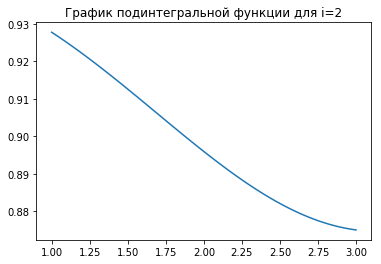

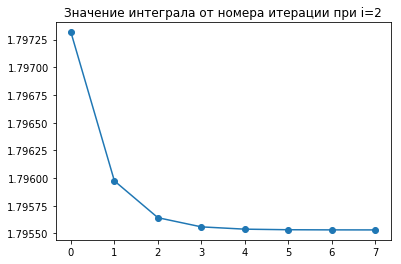

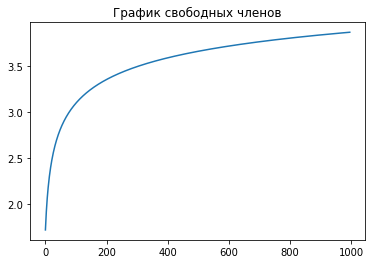

In [79]:
def f(t):
	return F(2,t)

plt.title('График подинтегральной функции для i=2')
plt.plot(linspace(a,b,100),f(linspace(a,b,100)))
plt.show()

trapz(f,a,b,inteps/100000,plot=True)

B=array([sila(i) for i in range(1,n)])
plt.title('График свободных членов')
plt.plot(B,'-')
plt.show()

Условия сходимости выполнены


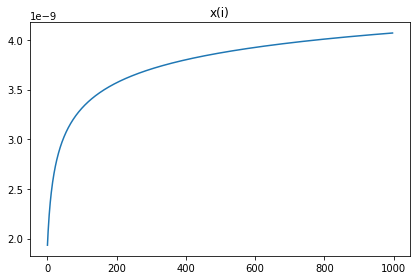

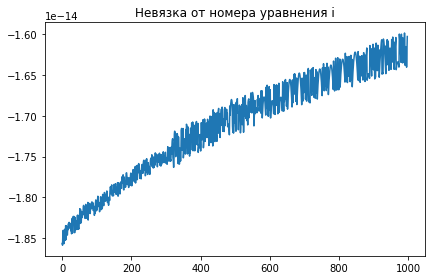

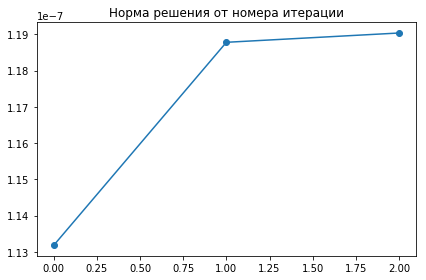

Количество итераций 3
Норма решения 1.1905056e-07, норма решения встроенной функцией 1.1905112275735518e-07
Число обусловленности 1.0659299281688122


In [82]:
if np.linalg.norm(alpha,ord=1):
	print('Условия сходимости выполнены')

Xk=beta
Xkk=np.ones(n)*10e9
E=np.identity(n)

t1=time.time() - start_time

N=0
norms=[]
while np.linalg.norm(Xk-Xkk)/np.linalg.norm(Xkk)>eps:
    N+=1
    norms.append(np.linalg.norm(Xk))
    Xkk=Xk
    Xk=alpha@Xkk+beta

r=(E-alpha)@Xk-beta

plt.title('x(i)')
plt.tight_layout()
plt.plot(Xk,'-')
plt.show()

plt.title('Невязка от номера уравнения i')
plt.tight_layout()
plt.plot(r,'-')
plt.show()

plt.title('Норма решения от номера итерации')
plt.tight_layout()
plt.plot(norms,'-o')
plt.show()
print('Количество итераций %s'%N)
print('Норма решения %s, норма решения встроенной функцией %s'%(np.linalg.norm(Xk), np.linalg.norm(x1)))
print('Число обусловленности',np.linalg.cond(E-alpha))